In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle


In [17]:


def valley_detection(dataset, fs):
    window = []
    valleylist = []
    listpos = 0
    TH_elapsed = np.ceil(0.36 * fs)
    nvalleys = 0
    valleyarray = []
    
    localaverage = np.average(dataset)
    for datapoint in dataset:
        if (datapoint > localaverage) and (len(window) < 1):
            listpos += 1
        elif (datapoint <= localaverage):
            window.append(datapoint)
            listpos += 1
        else:
            minimum = min(window)
            beatposition = listpos - len(window) + (window.index(minimum))
            valleylist.append(beatposition)
            window = []
            listpos += 1

    for val in valleylist:
        if nvalleys > 0:
            prev_valley = valleylist[nvalleys - 1]
            elapsed = val - prev_valley
            if elapsed > TH_elapsed:
                valleyarray.append(val)
        else:
            valleyarray.append(val)
        nvalleys += 1    
    return valleyarray

def pair_valley(valley):
    return [[valley[i], valley[i+1]] for i in range(len(valley)-1)]

def statistic_detection(signal, fs):
    valley = valley_detection(signal, fs)
    valley = pair_valley(valley)
    stds, kurtosiss, skews = [], [], []
    for v in valley:
        segment = signal[v[0]:v[1]]
        stds.append(np.std(segment))
        kurtosiss.append(stats.kurtosis(segment))
        skews.append(stats.skew(segment))
    return stds, kurtosiss, skews, valley

def statistic_threshold(clean_signal, fs, ths):
    stds, kurtosiss, skews, _ = statistic_detection(clean_signal, fs)
    std_ths = np.mean(stds) + ths[0]
    kurt_ths = np.mean(kurtosiss) + ths[1]
    skews_ths = [np.mean(skews) - ths[2], np.mean(skews) + ths[3]]
    return std_ths, kurt_ths, skews_ths

def eliminate_noise_in_time(data, fs, ths, cycle=15):
    stds, kurtosiss, skews, valley = statistic_detection(data, fs)
    stds_ = [np.mean(stds[i:i+cycle]) for i in range(0, len(stds)-cycle+1, cycle)]
    kurtosiss_ = [np.mean(kurtosiss[i:i+cycle]) for i in range(0, len(kurtosiss)-cycle+1, cycle)]
    skews_ = [np.mean(skews[i:i+cycle]) for i in range(0, len(skews)-cycle+1, cycle)]
    
    clean_indices = []
    for i in range(len(stds_)):
        if (stds_[i] < ths[0]) and (kurtosiss_[i] < ths[1]) and (skews_[i] > ths[2][0]) and (skews_[i] < ths[2][1]):
            start = valley[i*cycle][0]
            end = valley[i*cycle + cycle-1][1]
            clean_indices.extend(range(start, end))
    
    return len(data), len(clean_indices), clean_indices



In [ ]:
with open('data.pkl', 'rb') as f:
    data_dict = pickle.load(f)

def save_full_length_plots(user, condition, original_ppg, filtered_ppg, clean_indices, fs):
    time_original = np.arange(len(original_ppg)) / fs
    time_filtered = time_original[clean_indices]
    
    y_min = np.min(original_ppg) - 5
    y_max = np.max(original_ppg) + 5
    duration = len(original_ppg)/fs
    
   
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(duration/4, 6), sharex=True, sharey=True)
    
    # Исходный сигнал
    ax1.plot(time_original, original_ppg, 
            color='#1f77b4', linewidth=1, alpha=0.8)
    ax1.set_title(f'Исходный сигнал ({user}, {condition})\nДлительность: {duration:.1f} сек | STAI: {data_dict[user]["stress_lvl_for_stress"]}')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_ylim(y_min, y_max)
    
    # Отфильтрованный сигнал
    ax2.plot(time_filtered, filtered_ppg, 
            color='#9467bd', linewidth=1, alpha=0.8)
    ax2.set_title(f'Отфильтрованный сигнал\nСохранено: {len(filtered_ppg)} точек ({len(filtered_ppg)/len(original_ppg):.1%})')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_ylabel('Амплитуда')
    ax2.set_xlabel('Время (сек)')
    
    plt.tight_layout()
    plt.savefig(f'comparison_{user}_{condition}.png') 
    plt.close()


for user in data_dict:
    for condition in ['stress']:
        ppg = data_dict[user][f'PPG_{condition}']
        
        # Фильтрация всего сигнала
        ths = statistic_threshold(ppg, 64, [1.0, 2.0, 1.8, 1.5])
        _, _, clean_idx = eliminate_noise_in_time(ppg, 64, ths, 10)
        
        save_full_length_plots(
            user=user,
            condition=condition,
            original_ppg=ppg,
            filtered_ppg=ppg[clean_idx],
            clean_indices=clean_idx,
            fs=64
        )

In [ ]:
# Добавляем новые импорты
from scipy.signal import butter, lfilter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Полосовой фильтр Баттерворта"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)  # Используем фазово-независимую фильтрацию
    return y

def moving_average_enhanced(signal, window_size=5):
    """Улучшенное скользящее среднее с дополнением краев"""
    padding = np.ones(window_size//2) * signal[0]
    padded = np.concatenate([padding, signal, padding])
    weights = np.ones(window_size)/window_size
    return np.convolve(padded, weights, mode='valid')


# Модифицируем основной цикл обработки
for user in data_dict:
    for condition in ['stress']:
        ppg = data_dict[user][f'PPG_{condition}']
        
        
        # 2. Полосовая фильтрация (0.5-8 Hz)
        ppg_filtered = butter_bandpass_filter(ppg, 0.5, 5, 64)
        
        # 3. Улучшенное скользящее среднее
        ppg_smoothed = moving_average_enhanced(ppg_filtered, window_size=5)
        
      
        X = np.arange(len(ppg_smoothed)).reshape(-1, 1)
        model = LinearRegression().fit(X, ppg_smoothed)
        trend = model.predict(X)
        ppg_detrended = ppg_smoothed - trend
        
       
        # Оригинальная статистическая фильтрация
        ths = statistic_threshold(ppg_detrended, 64, [1.0, 1.5, 1.5, 1.2]) 
        _, _, clean_idx = eliminate_noise_in_time(ppg_detrended, 64, ths, 10)
        
        
        save_full_length_plots(
            user=user,
            condition=condition,
            original_ppg=ppg,
            filtered_ppg=ppg_detrended[clean_idx],  
            clean_indices=clean_idx,
            fs=64
        )

Фильтрация данных происходит, но требуемая точность не достигается. 

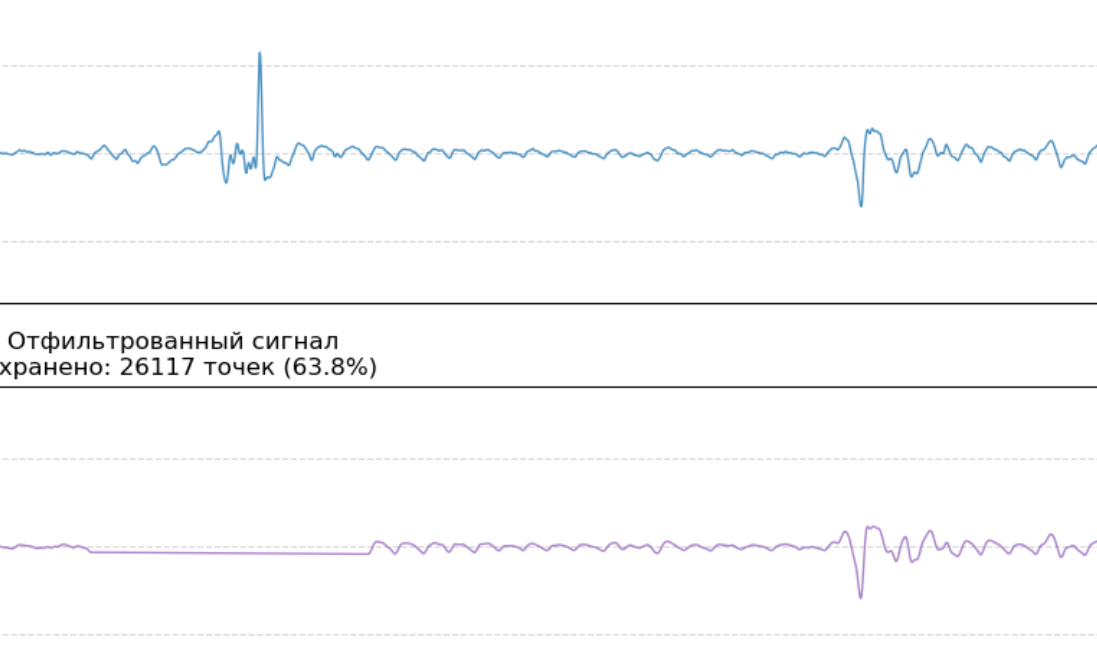